In [5]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re, string, os
import gensim, spacy, glove

from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from scipy import linalg, mat, dot
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.wrappers import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/sherlock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Load datasets

sick = open("SICK.txt", "r")
msr1 = open("msr_train.txt", "r")
msr2 = open("msr_test.txt", "r")
#ppdb = open("ppdb-2.0-l-all", "r")

## Data munging

In [19]:
def read_text_file(file):
    
    '''Reads lines in file and appends to a corpus list'''
    
    corpus = []
    for i, line in enumerate(file):
        if i==0:
            continue
        else:
            corpus.append(line)
    
    return corpus

In [20]:
def read_more_files(file1, file2=None):
    
    '''Reads lines in two files and appends them to a corpus list'''
    
    if file2==None:
        corpus = read_text_file(file1)
        
    else:
        corpus1 = read_text_file(file1)
        corpus2 = read_text_file(file2)
        corpus = corpus1 + corpus2
    
    print(len(corpus))
    return corpus   

In [21]:
# Implementation

#ppdb_corpus = read_more_files(ppdb)
#ppdb_corpus

.fasttext skipgram -input billwords_preprocessed.txt -dim 300 -thread 20 -minCount 5 -neg 5 -ws 5 -lr
0.025 -output modelft_sg.txt

./fasttext cbow -input billwords_preprocessed.txt -dim 300 -thread 20 -minCount 5 -neg 5 -ws 5 -lr
0.05 -output modelft_sg.txt

In [23]:
# Implementation

sick_corpus = read_more_files(sick)
sick_corpus

9840


['1\tA group of kids is playing in a yard and an old man is standing in the background\tA group of boys in a yard is playing and a man is standing in the background\tNEUTRAL\t4.5\tA_neutral_B\tB_neutral_A\tA group of children playing in a yard, a man in the background.\tA group of children playing in a yard, a man in the background.\tFLICKR\tFLICKR\tTRAIN\n',
 '2\tA group of children is playing in the house and there is no man standing in the background\tA group of kids is playing in a yard and an old man is standing in the background\tNEUTRAL\t3.2\tA_contradicts_B\tB_neutral_A\tA group of children playing in a yard, a man in the background.\tA group of children playing in a yard, a man in the background.\tFLICKR\tFLICKR\tTRAIN\n',
 '3\tThe young boys are playing outdoors and the man is smiling nearby\tThe kids are playing outdoors near a man with a smile\tENTAILMENT\t4.7\tA_entails_B\tB_entails_A\tThe children are playing outdoors, while a man smiles nearby.\tThe children are playing 

In [24]:
# Implementation

msr_corpus = read_more_files(msr1, msr2)
msr_corpus

5801


['1\t702876\t702977\tAmrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.\tReferring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.\n',
 "0\t2108705\t2108831\tYucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.\tYucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.\n",
 "1\t1330381\t1330521\tThey had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.\tOn June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.\n",
 '0\t3344667\t3344648\tAround 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.\tTab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.\n',
 '1\t1236820\t1236712\tThe stock rose $2.11, or about 11 percent, to close Friday at $21.51 on

In [25]:
def extract_sentences_scores(corpus):
    
    '''Creates a list of sentence pairs omitting punctuation and a list of similarity scores'''
    
    sentences, scores = [], []
    for line in corpus:
        words = line.split('\t')
        
        for i, word in enumerate(words):
            try:
                int(word[0])
                continue
                
            except:
                sent1 = words[i].lower().strip()
                sent2 = words[i+1].lower().strip()
                
                translator = str.maketrans("", "", string.punctuation)
                sent1 = sent1.translate(translator)
                sent2 = sent2.translate(translator)
                
                sentences.append([sent1, sent2])
                
                if i==1:
                    score = words[4]
                    scores.append(float(score))
                
                elif i==3:
                    score = words[0]
                    scores.append(float(score))
                
                break
            
            else: continue
        
    return sentences, scores

In [26]:
# Implementation

sick_sentences, sick_scores = extract_sentences_scores(sick_corpus)
msr_sentences, msr_scores = extract_sentences_scores(msr_corpus)

In [ ]:
sick_sentences

In [ ]:
msr_sentences

## Stemming and Lemmatization

In [27]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

def stemming_words(sentences):
    
    '''Stems words in sentences using Porter Stemmer'''
    
    porter_stemmer = PorterStemmer()
    
    sentences_stem = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            for word in words:
                sent_new.append(porter_stemmer.stem(word))
            doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        sentences_stem.append(pair_new)
    
    return sentences_stem
        

In [29]:
# Implementation

sick_sentences_stem = stemming_words(sick_sentences)
msr_sentences_stem = stemming_words(msr_sentences)

In [ ]:
sick_sentences_stem

In [ ]:
msr_sentences_stem

In [30]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    '''Gets POS tags from Wordnet'''
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''
    

In [31]:
from nltk import pos_tag

def pos_tagging(sentences):
    
    '''Part-of-Speech tagging using Wordnet treebank tags'''
    
    sentences_pos = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            tagged = pos_tag(words)
            for token, tag in tagged:
                wntag = get_wordnet_pos(tag)
                wordset = (token, wntag)
                sent_new.append(wordset)
            pair_new.append(sent_new) 
        sentences_pos.append(pair_new)
    
    return sentences_pos

In [32]:
# Implementation

sick_sentences_pos = pos_tagging(sick_sentences)
msr_sentences_pos = pos_tagging(msr_sentences)

In [ ]:
sick_sentences_pos

In [ ]:
msr_sentences_pos

In [33]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatizing_words(sentences):
    
    '''Lemmatizes words in sentences that are POS-tagged'''
    
    sentences_pos = pos_tagging(sentences)
    
    lemmatizer = WordNetLemmatizer()
    
    sentences_lemma = []
    for pair in sentences_pos:
        pair_new = []
        for sent in pair:
            sent_new = []
            for wordset in sent:
                try:
                    sent_new.append(lemmatizer.lemmatize(wordset[0], pos=wordset[1]))
                except:
                    sent_new.append(wordset[0])
                doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        sentences_lemma.append(pair_new)
    
    return sentences_lemma

In [34]:
# Implementation

sick_sentences_lemma = lemmatizing_words(sick_sentences)
msr_sentences_lemma = lemmatizing_words(msr_sentences)

In [ ]:
sick_sentences_lemma

In [ ]:
msr_sentences_lemma

## Filtering stopwords

In [35]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
    
def remove_stopwords(sentences, stopwords):
    
    '''Removes English stopwords from sentences'''
    
    filtered_words = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            for word in words:
                if word not in stopwords:
                    sent_new.append(word)
            doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        filtered_words.append(pair_new)
    
    return filtered_words

In [36]:
# Implementation

sick_filtered = remove_stopwords(sick_sentences_lemma, stopwords)
msr_filtered = remove_stopwords(msr_sentences_lemma, stopwords)

In [ ]:
sick_filtered

In [ ]:
msr_filtered

In [37]:
def convert_scores_to_binary(scores_list, threshold):
    
    '''Converts a percentage accuracy score to either a 0 or a 1'''
    
    bin_scores = []
    for score in scores_list:
        if score < threshold:
            bin_scores.append(0)
        else:
            bin_scores.append(1)
    
    return bin_scores

## Bag-of-Words model

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

def run_bow_model(sentences):
    
    '''Creates BoW model and calculates cosine similarity of each sentence pair'''
    
    count_vec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), 
                               max_df=1.0, min_df=0.5, max_features=None)
    
    bow_matrix, bow_scores = [], []
    for pair in sentences:
        bow_model = count_vec.fit_transform(pair).toarray()
        bow_matrix.append(bow_model)

        cos_sim = cosine_similarity(bow_model[0,:].reshape(1,-1), bow_model[1,:].reshape(1, -1))
        bow_scores.append(float(cos_sim))
        
    
    return bow_scores

In [119]:
# Implementation

sick_bow_scores = run_bow_model(sick_sentences)
msr_bow_scores = run_bow_model(msr_sentences)

sick_bow_stem_scores = run_bow_model(sick_sentences_stem)
msr_bow_stem_scores = run_bow_model(msr_sentences_stem)

sick_bow_lem_scores = run_bow_model(sick_sentences_lemma)
msr_bow_lem_scores = run_bow_model(msr_sentences_lemma)

sick_bow_stw_scores = run_bow_model(sick_filtered)
msr_bow_stw_scores = run_bow_model(msr_filtered)

In [120]:
sick_bow_scores

[0.5728918992315463,
 0.501280411827603,
 0.3344968040028363,
 0.647150228929434,
 0.3113995776646092,
 0.17213259316477406,
 0.23076923076923078,
 0.15384615384615385,
 0.14322297480788657,
 0.8362420100070908,
 0.7272727272727273,
 0.25819888974716115,
 0.6,
 0.0,
 0.13483997249264842,
 0.0,
 0.0,
 0.0,
 0.8181818181818181,
 0.8181818181818181,
 0.7272727272727273,
 0.8819171036881968,
 0.8451542547285165,
 0.10050378152592121,
 0.0,
 0.0,
 0.0,
 0.11396057645963795,
 0.11396057645963795,
 0.6363636363636364,
 0.8040302522073697,
 0.5017452060042544,
 0.5853694070049635,
 0.40201512610368484,
 0.16724840200141816,
 0.0,
 0.09090909090909091,
 0.20100756305184242,
 0.08362420100070908,
 0.18181818181818182,
 0.5714285714285713,
 0.9999999999999998,
 0.5714285714285713,
 0.629940788348712,
 0.629940788348712,
 0.1259881576697424,
 0.1259881576697424,
 0.0,
 0.14285714285714282,
 0.14285714285714282,
 0.14285714285714282,
 0.7777777777777777,
 0.6666666666666666,
 0.6030226891555273,
 0

In [121]:
msr_bow_scores

[0.7333333333333332,
 0.26462806201248157,
 0.5564148840746572,
 0.4199605255658081,
 0.4170288281141496,
 0.838870492807861,
 0.16692446522239715,
 0.40201512610368484,
 0.2666666666666666,
 0.6515837655350014,
 0.6492344540642356,
 0.8007572173962101,
 0.33333333333333326,
 0.6999132392733555,
 0.731310340973526,
 0.5459486832355505,
 0.5335783750799326,
 0.7241379310344828,
 0.45873171092556453,
 0.8196885999705369,
 0.7229568912920511,
 0.6565706694547586,
 0.5806451612903227,
 0.5726562866781999,
 0.6196773353931867,
 0.41702882811414954,
 0.6370220572706062,
 0.4131182235954578,
 0.7341303483857977,
 0.2503130871608794,
 0.48280787926033486,
 0.4800793585191833,
 0.46709936649691375,
 0.4303314829119351,
 0.5999999999999999,
 0.2817180849095055,
 0.269069117598525,
 0.5449492609130661,
 0.6470588235294117,
 0.4850712500726659,
 0.500244319584578,
 0.5017452060042544,
 0.6761234037828132,
 0.23076923076923078,
 0.5243041203911969,
 0.6956521739130436,
 0.7341303483857976,
 0.42966

In [122]:
df_sick_bow = pd.DataFrame({'Relatedness': sick_scores, 'BoW': sick_bow_scores, 'BoW_stem': sick_bow_stem_scores,
                           'BoW_lemma': sick_bow_lem_scores, 'BoW_filt': sick_bow_stw_scores})
df_sick_bow

,Relatedness,BoW,BoW_stem,BoW_lemma,BoW_filt
0,4.500,0.572892,0.572892,0.572892,0.572892
1,3.200,0.501280,0.501280,0.501280,0.501280
2,4.700,0.334497,0.501745,0.501745,0.501745
3,3.600,0.647150,0.832050,0.554700,0.554700
4,3.400,0.311400,0.311400,0.311400,0.311400
5,3.300,0.172133,0.172133,0.086066,0.086066
6,3.700,0.230769,0.230769,0.230769,0.230769
7,3.000,0.153846,0.153846,0.153846,0.153846
8,3.700,0.143223,0.143223,0.143223,0.143223
9,4.900,0.836242,0.859338,0.836242,0.836242


In [123]:
# Pearson's correlation of scores
df_sick_bow.corr(method='pearson')

,Relatedness,BoW,BoW_stem,BoW_lemma,BoW_filt
Relatedness,1.000000,0.545892,0.568393,0.569404,0.569422
BoW,0.545892,1.000000,0.972989,0.965416,0.965419
BoW_stem,0.568393,0.972989,1.000000,0.981616,0.981618
BoW_lemma,0.569404,0.965416,0.981616,1.000000,0.999999
BoW_filt,0.569422,0.965419,0.981618,0.999999,1.000000


In [124]:
# Spearman's correlation of scores
df_sick_bow.corr(method='spearman')

,Relatedness,BoW,BoW_stem,BoW_lemma,BoW_filt
Relatedness,1.000000,0.548808,0.560434,0.563330,0.563354
BoW,0.548808,1.000000,0.971279,0.964409,0.964414
BoW_stem,0.560434,0.971279,1.000000,0.982938,0.982943
BoW_lemma,0.563330,0.964409,0.982938,1.000000,0.999999
BoW_filt,0.563354,0.964414,0.982943,0.999999,1.000000


In [126]:
# Convert scores to binary

msr_bow_binscores = convert_scores_to_binary(msr_bow_scores, 0.7)
msr_bow_stem_binscores = convert_scores_to_binary(msr_bow_stem_scores, 0.7)
msr_bow_lem_binscores = convert_scores_to_binary(msr_bow_lem_scores, 0.7)
msr_bow_stw_binscores = convert_scores_to_binary(msr_bow_stw_scores, 0.7)

In [128]:
df_msr_bow = pd.DataFrame({'Similarity': msr_scores, 'BoW': msr_bow_binscores, 'BoW_stem': msr_bow_stem_binscores,
                           'BoW_lemma': msr_bow_lem_binscores, 'BoW_filt': msr_bow_stw_binscores})
df_msr_bow

,Similarity,BoW,BoW_stem,BoW_lemma,BoW_filt
0,1.0,1,1,1,1
1,0.0,0,0,0,0
2,1.0,0,0,0,0
3,0.0,0,0,0,0
4,1.0,0,0,0,0
5,1.0,1,1,1,1
6,0.0,0,0,0,0
7,1.0,0,0,0,0
8,0.0,0,0,0,0
9,1.0,0,0,0,0


In [164]:
# Confusion matrix of BoW scores

#plt.figure(figsize=(6, 4))

msr_bow_cf = pd.DataFrame(confusion_matrix(df_msr_bow['Similarity'], df_msr_bow['BoW']),  
                      columns=['BoW 0', 'BoW 1'], index=['MSR 0', 'MSR 1'])

msr_bow_acc = accuracy_score(df_msr_bow['Similarity'], df_msr_bow['BoW'])

msr_bow_stem_cf = pd.DataFrame(confusion_matrix(df_msr_bow['Similarity'], df_msr_bow['BoW_stem']),  
                      columns=['BoW_stem 0', 'BoW_stem 1'], index=['MSR 0', 'MSR 1'])

msr_bow_stem_acc = accuracy_score(df_msr_bow['Similarity'], df_msr_bow['BoW_stem'])

msr_bow_lem_cf = pd.DataFrame(confusion_matrix(df_msr_bow['Similarity'], df_msr_bow['BoW_lemma']),  
                      columns=['BoW_lemma 0', 'BoW_lemma 1'], index=['MSR 0', 'MSR 1'])

msr_bow_lem_acc = accuracy_score(df_msr_bow['Similarity'], df_msr_bow['BoW_lemma'])

msr_bow_stw_cf = pd.DataFrame(confusion_matrix(df_msr_bow['Similarity'], df_msr_bow['BoW_filt']),  
                      columns=['BoW_filt 0', 'BoW_filt 1'], index=['MSR 0', 'MSR 1'])

msr_bow_stw_acc = accuracy_score(df_msr_bow['Similarity'], df_msr_bow['BoW_filt'])

#sns.heatmap(msr_bow_cf, annot=True, cmap='Blues')
#plt.show()
display(msr_bow_cf)
print('Accuracy:', msr_bow_acc)
display(msr_bow_stem_cf)
print('Accuracy:', msr_bow_stem_acc)
display(msr_bow_lem_cf)
print('Accuracy:', msr_bow_lem_acc)
display(msr_bow_stw_cf)
print('Accuracy:', msr_bow_stw_acc)

,BoW 0,BoW 1
MSR 0,1723,178
MSR 1,2682,1218


Accuracy: 0.5069815549043268


,BoW_stem 0,BoW_stem 1
MSR 0,1692,209
MSR 1,2522,1378


Accuracy: 0.5292191001551456


,BoW_lemma 0,BoW_lemma 1
MSR 0,1695,206
MSR 1,2552,1348


Accuracy: 0.5245647302189278


,BoW_filt 0,BoW_filt 1
MSR 0,1695,206
MSR 1,2548,1352


Accuracy: 0.5252542665057749


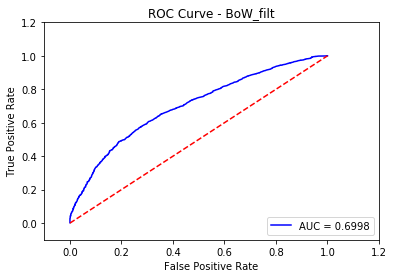

In [171]:
# ROC curve and AUC score

plt.figure(figsize=(6, 4))
# ROC curve; AUC score
fpr, tpr, thresholds = roc_curve(msr_scores, msr_bow_stw_scores, pos_label=1)
roc_auc_dt = auc(fpr, tpr)

plt.title('ROC Curve - BoW_filt')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.4f'% roc_auc_dt)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## TF-IDF model

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer

def run_tfidf_model(sentences):
    
    '''Creates TF-IDF model and calculates cosine similarity of each sentence pair'''
    
    tfidf_vec = TfidfVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), 
                               max_df=1.0, min_df=0.5, max_features=None)
    
    tfidf_matrix, tfidf_scores = [], []
    for pair in sentences:
        tfidf_model = tfidf_vec.fit_transform(pair).toarray()
        tfidf_matrix.append(tfidf_model)

        cos_sim = cosine_similarity(tfidf_model[0,:].reshape(1,-1), tfidf_model[1,:].reshape(1, -1))
        tfidf_scores.append(float(cos_sim))
           
    return tfidf_scores

In [141]:
# Implementation

sick_tfidf_scores = run_tfidf_model(sick_sentences)
msr_tfidf_scores = run_tfidf_model(msr_sentences)

sick_tfidf_stem_scores = run_tfidf_model(sick_sentences_stem)
msr_tfidf_stem_scores = run_tfidf_model(msr_sentences_stem)

sick_tfidf_lem_scores = run_tfidf_model(sick_sentences_lemma)
msr_tfidf_lem_scores = run_tfidf_model(msr_sentences_lemma)

sick_tfidf_stw_scores = run_tfidf_model(sick_filtered)
msr_tfidf_stw_scores = run_tfidf_model(msr_filtered)

In [142]:
sick_tfidf_scores

[0.40499207708880364,
 0.33761884058117697,
 0.20300559411092822,
 0.4871909039824688,
 0.18677053629508622,
 0.09555392669038872,
 0.13184888076608314,
 0.08428628150824312,
 0.07803972866541829,
 0.7241072696029363,
 0.5744651733947116,
 0.1506401849870651,
 0.43161341897075145,
 0.0,
 0.07357474610589511,
 0.0,
 0.0,
 0.0,
 0.6949450440198668,
 0.6949450440198668,
 0.5744651733947116,
 0.7995189954301453,
 0.7474073540060464,
 0.05355095314996731,
 0.0,
 0.0,
 0.0,
 0.06123094334544522,
 0.06123094334544522,
 0.4697567680115259,
 0.6787551892030775,
 0.3381735228927155,
 0.41764463587730527,
 0.25431642559716855,
 0.09232139829308136,
 0.0,
 0.04818505752489927,
 0.1130407841661348,
 0.04416443453527434,
 0.10112251282501054,
 0.40298220897396103,
 1.0000000000000004,
 0.40298220897396103,
 0.4652915323370137,
 0.4652915323370137,
 0.06804963087832473,
 0.06804963087832473,
 0.0,
 0.07780894359285004,
 0.07780894359285004,
 0.07780894359285004,
 0.6392306240536286,
 0.50310261241513

In [143]:
msr_tfidf_scores

[0.5819696692214292,
 0.15425058744996145,
 0.38869768049207154,
 0.26892262404706985,
 0.26908156278399686,
 0.7388743623629188,
 0.09210891560221621,
 0.25431642559716855,
 0.15546868561502203,
 0.4887171627133085,
 0.5003206826644747,
 0.6813641385642955,
 0.2019930924979184,
 0.5495073583195895,
 0.5875876636805754,
 0.37990233072398494,
 0.37010910479107995,
 0.570610969585164,
 0.3003323611066084,
 0.6985659570523982,
 0.5850833984252912,
 0.49199950285807437,
 0.41209434435019365,
 0.408261168230341,
 0.46172998028143597,
 0.2751003673954325,
 0.4707920225783794,
 0.26554865545898687,
 0.5879270118247929,
 0.14461901945292333,
 0.3212872067167935,
 0.3190404834496687,
 0.3088048415820829,
 0.279792482388136,
 0.43161341897075156,
 0.16610441986331423,
 0.15924770947631645,
 0.37974565395305393,
 0.4813584526328446,
 0.32994345523514607,
 0.33638663841316874,
 0.3381735228927155,
 0.5193879933129156,
 0.1318488807660832,
 0.3600390903120264,
 0.5364208790989098,
 0.58792701182479

In [144]:
df_sick_tfidf = pd.DataFrame({'Relatedness': sick_scores, 'TF-IDF': sick_tfidf_scores, 
                              'TF-IDF_stem': sick_tfidf_stem_scores, 'TF-IDF_lemma': sick_tfidf_lem_scores, 
                              'TF-IDF_filt': sick_tfidf_stw_scores})
df_sick_tfidf

,Relatedness,TF-IDF,TF-IDF_stem,TF-IDF_lemma,TF-IDF_filt
0,4.500,0.404992,0.404992,0.404992,0.404992
1,3.200,0.337619,0.337619,0.337619,0.337619
2,4.700,0.203006,0.338174,0.338174,0.338174
3,3.600,0.487191,0.729728,0.390186,0.390186
4,3.400,0.186771,0.186771,0.186771,0.186771
5,3.300,0.095554,0.095554,0.045574,0.045574
6,3.700,0.131849,0.131849,0.131849,0.131849
7,3.000,0.084286,0.084286,0.084286,0.084286
8,3.700,0.078040,0.078040,0.078040,0.078040
9,4.900,0.724107,0.758156,0.724107,0.724107


In [145]:
# Pearson's correlation of scores
df_sick_tfidf.corr(method='pearson')

,Relatedness,TF-IDF,TF-IDF_stem,TF-IDF_lemma,TF-IDF_filt
Relatedness,1.000000,0.472194,0.493539,0.494923,0.494934
TF-IDF,0.472194,1.000000,0.974425,0.965412,0.965413
TF-IDF_stem,0.493539,0.974425,1.000000,0.976208,0.976209
TF-IDF_lemma,0.494923,0.965412,0.976208,1.000000,1.000000
TF-IDF_filt,0.494934,0.965413,0.976209,1.000000,1.000000


In [146]:
# Spearman's correlation of scores
df_sick_tfidf.corr(method='spearman')

,Relatedness,TF-IDF,TF-IDF_stem,TF-IDF_lemma,TF-IDF_filt
Relatedness,1.000000,0.548133,0.559361,0.561944,0.561968
TF-IDF,0.548133,1.000000,0.971182,0.964537,0.964542
TF-IDF_stem,0.559361,0.971182,1.000000,0.982808,0.982812
TF-IDF_lemma,0.561944,0.964537,0.982808,1.000000,0.999999
TF-IDF_filt,0.561968,0.964542,0.982812,0.999999,1.000000


In [147]:
# Convert scores to binary

msr_tfidf_binscores = convert_scores_to_binary(msr_tfidf_scores, 0.7)
msr_tfidf_stem_binscores = convert_scores_to_binary(msr_tfidf_stem_scores, 0.7)
msr_tfidf_lem_binscores = convert_scores_to_binary(msr_tfidf_lem_scores, 0.7)
msr_tfidf_stw_binscores = convert_scores_to_binary(msr_tfidf_stw_scores, 0.7)

msr_scores = convert_scores_to_binary(msr_scores)

In [148]:
df_msr_tfidf = pd.DataFrame({'Similarity': msr_scores, 'TF-IDF': msr_tfidf_binscores, 
                             'TF-IDF_stem': msr_tfidf_stem_binscores, 'TF-IDF_lemma': msr_tfidf_lem_binscores, 
                             'TF-IDF_filt': msr_tfidf_stw_binscores})
df_msr_tfidf

,Similarity,TF-IDF,TF-IDF_stem,TF-IDF_lemma,TF-IDF_filt
0,1,0,0,0,0
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,1,0,0,0,0
5,1,1,1,1,1
6,0,0,0,0,0
7,1,0,0,0,0
8,0,0,0,0,0
9,1,0,0,0,0


In [163]:
# Confusion matrix of TF-IDF scores

#plt.figure(figsize=(6, 4))

msr_tfidf_cf = pd.DataFrame(confusion_matrix(df_msr_tfidf['Similarity'], df_msr_tfidf['TF-IDF']),  
                      columns=['TF-IDF 0', 'TF-IDF 1'], index=['MSR 0', 'MSR 1'])

msr_tfidf_acc = accuracy_score(df_msr_tfidf['Similarity'], df_msr_tfidf['TF-IDF'])

msr_tfidf_stem_cf = pd.DataFrame(confusion_matrix(df_msr_tfidf['Similarity'], df_msr_tfidf['TF-IDF_stem']),  
                      columns=['TF-IDF_stem 0', 'TF-IDF_stem 1'], index=['MSR 0', 'MSR 1'])

msr_tfidf_stem_acc = accuracy_score(df_msr_tfidf['Similarity'], df_msr_tfidf['TF-IDF_stem'])

msr_tfidf_lem_cf = pd.DataFrame(confusion_matrix(df_msr_tfidf['Similarity'], df_msr_tfidf['TF-IDF_lemma']),  
                      columns=['TF-IDF_lemma 0', 'TF-IDF_lemma 1'], index=['MSR 0', 'MSR 1'])

msr_tfidf_lem_acc = accuracy_score(df_msr_tfidf['Similarity'], df_msr_tfidf['TF-IDF_lemma'])

msr_tfidf_stw_cf = pd.DataFrame(confusion_matrix(df_msr_tfidf['Similarity'], df_msr_tfidf['TF-IDF_filt']),  
                      columns=['TF-IDF_filt 0', 'TF-IDF_filt 1'], index=['MSR 0', 'MSR 1'])

msr_tfidf_stw_acc = accuracy_score(df_msr_tfidf['Similarity'], df_msr_tfidf['TF-IDF_filt'])

#sns.heatmap(msr_tfidf_cf, annot=True, cmap='Blues')
#plt.show()
display(msr_tfidf_cf)
print('Accuracy:', msr_tfidf_acc)
display(msr_tfidf_stem_cf)
print('Accuracy:', msr_tfidf_stem_acc)
display(msr_tfidf_lem_cf)
print('Accuracy:', msr_tfidf_lem_acc)
display(msr_tfidf_stw_cf)
print('Accuracy:', msr_tfidf_stw_acc)

,TF-IDF 0,TF-IDF 1
MSR 0,1866,35
MSR 1,3561,339


Accuracy: 0.3801068781244613


,TF-IDF_stem 0,TF-IDF_stem 1
MSR 0,1864,37
MSR 1,3469,431


Accuracy: 0.39562144457852094


,TF-IDF_lemma 0,TF-IDF_lemma 1
MSR 0,1860,41
MSR 1,3464,436


Accuracy: 0.3957938286502327


,TF-IDF_filt 0,TF-IDF_filt 1
MSR 0,1860,41
MSR 1,3464,436


Accuracy: 0.3957938286502327


## Word2Vec

In [25]:
# Load Google's pre-trained Word2Vec model
modelwd_pret = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [26]:
modelwd_pret['dog']

array([ 5.12695312e-02, -2.23388672e-02, -1.72851562e-01,  1.61132812e-01,
       -8.44726562e-02,  5.73730469e-02,  5.85937500e-02, -8.25195312e-02,
       -1.53808594e-02, -6.34765625e-02,  1.79687500e-01, -4.23828125e-01,
       -2.25830078e-02, -1.66015625e-01, -2.51464844e-02,  1.07421875e-01,
       -1.99218750e-01,  1.59179688e-01, -1.87500000e-01, -1.20117188e-01,
        1.55273438e-01, -9.91210938e-02,  1.42578125e-01, -1.64062500e-01,
       -8.93554688e-02,  2.00195312e-01, -1.49414062e-01,  3.20312500e-01,
        3.28125000e-01,  2.44140625e-02, -9.71679688e-02, -8.20312500e-02,
       -3.63769531e-02, -8.59375000e-02, -9.86328125e-02,  7.78198242e-03,
       -1.34277344e-02,  5.27343750e-02,  1.48437500e-01,  3.33984375e-01,
        1.66015625e-02, -2.12890625e-01, -1.50756836e-02,  5.24902344e-02,
       -1.07421875e-01, -8.88671875e-02,  2.49023438e-01, -7.03125000e-02,
       -1.59912109e-02,  7.56835938e-02, -7.03125000e-02,  1.19140625e-01,
        2.29492188e-01,  

In [27]:
modelwd_pret.most_similar(positive=['yes', 'yeah'])

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Yeah', 0.7643884420394897),
 ('hey', 0.7373077869415283),
 ('Yes', 0.7288317680358887),
 ('Uh', 0.7206948399543762),
 ('mso_style_qformat', 0.7124799489974976),
 ('Oh', 0.7074445486068726),
 ('mso_style_noshow', 0.7043254971504211),
 ('Yeah_yeah', 0.6987195014953613),
 ('Oh_yeah', 0.6973084211349487),
 ('SADY', 0.6953877806663513)]

In [28]:
modelwd_pret.similarity('good', 'great')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.72915095

In [39]:
def create_words_list(sentences):
    
    '''Creates a list with separate words in each sentence'''
    
    words_list = []

    for pair in sentences:
        pair_new = []
        for sent in pair:
            words = sent.split()
            pair_new.append(words)

        words_list.append(pair_new)
    
    return words_list

In [40]:
# Implementation

sick_words_list = create_words_list(sick_filtered)
msr_words_list = create_words_list(msr_filtered)

In [ ]:
sick_words_list

In [ ]:
msr_words_list

In [16]:
def run_gensim_model(words_list, model):
    
    '''Runs Word2Vec and GloVe models in gensim and computes cosine similarity scores for each sentence pair'''
    
    matrix_list, scores = [], []

    for pair in words_list:
        sum_list = []
        for sent in pair:
            embeddings_list = []
            for word in sent:
                try:
                    embeddings_list.append(model[word])
                except:
                    embeddings_list.append(np.array(0))
            sum_list.append(sum(embeddings_list)/len(embeddings_list))
    
        matrix_list.append(sum_list)
        cos_sim = cosine_similarity(sum_list[0].reshape(1, -1), sum_list[1].reshape(1, -1))
        #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        scores.append(float(cos_sim))
        
    return scores

In [32]:
# Implementation

sick_wdpret_scores = run_gensim_model(sick_words_list, modelwd_pret)
msr_wdpret_scores = run_gensim_model(msr_words_list, modelwd_pret)

In [ ]:
sick_wdpret_scores

In [ ]:
msr_wdpret_scores

In [17]:
def run_spacy_model(words_list, model):
    
    '''Runs Word2Vec and GloVe models in SpaCy and computes cosine similarity scores for each sentence pair'''
    
    scores = []
    for pair in words_list:
        token1 = model(pair[0])
        token2 = model(pair[1])
        scores.append(token1.similarity(token2))

    return scores

In [34]:
modelwd_spacy = spacy.load("en", vectors="GoogleNews-vectors-negative300.bin")

In [35]:
# Implementation

sick_wdspacy_scores = run_spacy_model(sick_filtered, modelwd_spacy)
msr_wdspacy_scores = run_spacy_model(msr_filtered, modelwd_spacy)

In [ ]:
sick_wdspacy_scores

In [ ]:
msr_wdspacy_scores

In [ ]:
# Save UTF-8 version of text for training

billwords_raw = open("/project/1-billion-word-language-modeling-benchmark-r13output.tar", "r", encoding="ISO-8859-1")
billwords_clean = open('/project/billion_words_dataset/billwords_preprocessed.txt', 'w')

for i, line in enumerate(billwords_raw):
    if i==0:
        pos = line.find("While")
        line = line[pos:]
        
    billwords_clean.write(line)                

billwords_raw.close()
billwords_clean.close()

In [12]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
    
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            translator = str.maketrans("", "", string.punctuation)
            for line in open(os.path.join(self.dirname, fname)):
                line = line.translate(translator)
                line = line.lower().strip()
                yield line.split()

In [4]:
# Assign documents to directory of dataset for training

documents = MySentences("/project/billion_words_dataset")

In [5]:
# Train CBOW model

modelwd_cbow = Word2Vec(documents, size=300, window=5, min_count=5, workers=20, negative=5, sg=0)
#modelwd_train.train(documents, total_examples=len(documents), epochs=20)

In [6]:
# Train Skip-Gram model

modelwd_sg = Word2Vec(documents, size=300, window=5, min_count=5, workers=20, negative=5, sg=1)

In [184]:
# Save CBOW model

modelwd_cbow.wv.save_word2vec_format('modelwd_cbow.bin', binary=True)

In [185]:
# Save Skip-Gram model

modelwd_sg.wv.save_word2vec_format('modelwd_sg.bin', binary=True)

In [36]:
modelwd_cbow.wv.most_similar(positive='good', negative='bad')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('robinsono', 0.6505134105682373),
 ('cotts', 0.6451646685600281),
 ('weitzelo', 0.6422103643417358),
 ('barwin', 0.6198377013206482),
 ('boortz', 0.6174759864807129),
 ('johnell', 0.6169571876525879),
 ('atchley', 0.6113066077232361),
 ('karlinsky', 0.5977506637573242),
 ('katyal', 0.5735813975334167),
 ('varnum', 0.5710670351982117)]

In [37]:
modelwd_cbow.wv.similarity('person', 'people')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.48818558

In [38]:
sick_wdcbow_scores = run_gensim_model(sick_words_list, modelwd_cbow)
msr_wdcbow_scores = run_gensim_model(msr_words_list, modelwd_cbow)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
sick_wdcbow_scores

In [ ]:
msr_wdcbow_scores

In [39]:
sick_wdsg_scores = run_gensim_model(sick_words_list, modelwd_sg)
msr_wdsg_scores = run_gensim_model(msr_words_list, modelwd_sg)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
sick_wdsg_scores

In [ ]:
msr_wdsg_scores

In [40]:
df_sick_w2v = pd.DataFrame({'Relatedness': sick_scores, 'Word2Vec_gensim': sick_wdpret_scores, 
                            'Word2Vec_spacy': sick_wdspacy_scores, 'Word2Vec_cbow': sick_wdcbow_scores,
                            'Word2Vec_sg': sick_wdsg_scores})
df_sick_w2v

,Relatedness,Word2Vec_gensim,Word2Vec_spacy,Word2Vec_cbow,Word2Vec_sg
0,4.500,0.963674,0.934471,0.936647,0.951577
1,3.200,0.830682,0.929274,0.840805,0.870387
2,4.700,0.921303,0.906845,0.909995,0.931410
3,3.600,0.939009,0.906082,0.919940,0.936252
4,3.400,0.734106,0.821168,0.746335,0.747096
5,3.300,0.707422,0.758366,0.718379,0.699687
6,3.700,0.725023,0.735679,0.755996,0.752587
7,3.000,0.661670,0.663246,0.662835,0.680367
8,3.700,0.744693,0.770172,0.734949,0.730587
9,4.900,0.970822,0.981019,0.972881,0.968408


In [41]:
df_sick_w2v.corr(method='pearson')

,Relatedness,Word2Vec_gensim,Word2Vec_spacy,Word2Vec_cbow,Word2Vec_sg
Relatedness,1.000000,0.710151,0.500123,0.619914,0.696689
Word2Vec_gensim,0.710151,1.000000,0.753489,0.930165,0.985541
Word2Vec_spacy,0.500123,0.753489,1.000000,0.777478,0.773069
Word2Vec_cbow,0.619914,0.930165,0.777478,1.000000,0.948410
Word2Vec_sg,0.696689,0.985541,0.773069,0.948410,1.000000


In [42]:
df_sick_w2v.corr(method='spearman')

,Relatedness,Word2Vec_gensim,Word2Vec_spacy,Word2Vec_cbow,Word2Vec_sg
Relatedness,1.000000,0.590669,0.473922,0.548781,0.587305
Word2Vec_gensim,0.590669,1.000000,0.835134,0.947425,0.984737
Word2Vec_spacy,0.473922,0.835134,1.000000,0.846246,0.855543
Word2Vec_cbow,0.548781,0.947425,0.846246,1.000000,0.960490
Word2Vec_sg,0.587305,0.984737,0.855543,0.960490,1.000000


In [43]:
# Convert scores to binary

msr_wdpret_binscores = convert_scores_to_binary(msr_wdpret_scores, 0.7)
msr_wdspacy_binscores = convert_scores_to_binary(msr_wdspacy_scores, 0.7)
msr_wdcbow_binscores = convert_scores_to_binary(msr_wdcbow_scores, 0.7)
msr_wdsg_binscores = convert_scores_to_binary(msr_wdsg_scores, 0.7)

In [44]:
df_msr_w2v = pd.DataFrame({'Similarity': msr_scores, 'Word2Vec_gensim': msr_wdpret_binscores, 
                           'Word2Vec_spacy': msr_wdspacy_binscores, 'Word2Vec_cbow': msr_wdcbow_binscores,
                           'Word2Vec_sg': msr_wdsg_binscores})
df_msr_w2v

,Similarity,Word2Vec_gensim,Word2Vec_spacy,Word2Vec_cbow,Word2Vec_sg
0,1.0,1,1,1,1
1,0.0,1,1,1,1
2,1.0,1,1,1,1
3,0.0,1,1,1,1
4,1.0,1,1,1,1
5,1.0,1,1,1,1
6,0.0,1,1,1,1
7,1.0,1,1,1,1
8,0.0,1,1,1,1
9,1.0,1,1,1,1


In [172]:
# Confusion matrix of Word2Vec scores

#plt.figure(figsize=(6, 4))

msr_wdpret_cf = pd.DataFrame(confusion_matrix(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_gensim']),  
                      columns=['W2V_gensim 0', 'W2V_gensim 1'], index=['MSR 0', 'MSR 1'])

msr_wdpret_acc = accuracy_score(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_gensim'])

msr_wdspacy_cf = pd.DataFrame(confusion_matrix(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_spacy']),  
                      columns=['W2V_spacy 0', 'W2V_spacy 1'], index=['MSR 0', 'MSR 1'])

msr_wdspacy_acc = accuracy_score(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_spacy'])

msr_wdcbow_cf = pd.DataFrame(confusion_matrix(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_cbow']),  
                      columns=['W2V_cbow 0', 'W2V_cbow 1'], index=['MSR 0', 'MSR 1'])

msr_wdcbow_acc = accuracy_score(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_cbow'])

msr_wdsg_cf = pd.DataFrame(confusion_matrix(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_sg']),  
                      columns=['W2V_sg 0', 'W2V_sg 1'], index=['MSR 0', 'MSR 1'])

msr_wdsg_acc = accuracy_score(df_msr_w2v['Similarity'], df_msr_w2v['Word2Vec_sg'])

#sns.heatmap(msr_wdpret_cf, annot=True, cmap='Blues')
#plt.show()
display(msr_wdpret_cf)
print('Accuracy:', msr_wdpret_acc)
display(msr_wdspacy_cf)
print('Accuracy:', msr_wdspacy_acc)
display(msr_wdcbow_cf)
print('Accuracy:', msr_wdcbow_acc)
display(msr_wdsg_cf)
print('Accuracy:', msr_wdsg_acc)

,W2V_gensim 0,W2V_gensim 1
MSR 0,190,1711
MSR 1,91,3809


Accuracy: 0.6893639027753835


,W2V_spacy 0,W2V_spacy 1
MSR 0,9,1892
MSR 1,14,3886


Accuracy: 0.6714359593173591


,W2V_cbow 0,W2V_cbow 1
MSR 0,330,1571
MSR 1,249,3651


Accuracy: 0.6862609894845716


,W2V_sg 0,W2V_sg 1
MSR 0,15,1886
MSR 1,10,3890


Accuracy: 0.6731598000344768


## GloVe

In [10]:
# Load pretrained corpus of GloVe vectors

glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")

modelgl_pret = KeyedVectors.load_word2vec_format('gensim_glove_vectors.txt', binary=False)  

In [41]:
# Implementation

sick_glpret_scores = run_gensim_model(sick_words_list, modelgl_pret)
msr_glpret_scores = run_gensim_model(msr_words_list, modelgl_pret)

In [ ]:
sick_glpret_scores

In [ ]:
msr_glpret_scores

In [ ]:
#modelgl_spacy = spacy.load("en_vectors_web_lg")

In [42]:
modelgl_spacy = spacy.load("en", vectors="glove.6B.300d.txt")

In [43]:
# Implementation

sick_glspacy_scores = run_spacy_model(sick_filtered, modelgl_spacy)
msr_glspacy_scores = run_spacy_model(msr_filtered, modelgl_spacy)

In [ ]:
sick_glspacy_scores

In [ ]:
msr_glspacy_scores

In [13]:
from glove import Corpus, Glove

def run_glove_model(words_list, model):
    
    '''Runs GloVe model in glove and computes cosine similarity scores for each sentence pair'''
    
    matrix_list, scores = [], []

    for pair in words_list:
        sum_list = []
        for sent in pair:
            embeddings_list = []
            for word in sent:
                try:
                    embeddings_list.append(model.word_vectors[model.dictionary[word]])
                except:
                    embeddings_list.append(np.array(0))
            sum_list.append(sum(embeddings_list)/len(embeddings_list))
    
        matrix_list.append(sum_list)
        cos_sim = cosine_similarity(sum_list[0].reshape(1, -1), sum_list[1].reshape(1, -1))
        #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        scores.append(float(cos_sim))
        
    return scores

In [14]:
# Train GloVe model using dataset assigned to documents

documents = MySentences("/project/billion_words_dataset")

corpus = Corpus()

corpus.fit(documents, window=5)
 
modelgl_train = Glove(no_components=300, learning_rate=0.05)

In [15]:
# Train model with epochs

modelgl_train.fit(corpus.matrix, epochs=5, no_threads=20, verbose=True)

Performing 5 training epochs with 20 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [16]:
# Add word embeddings to corpus dictionary

modelgl_train.add_dictionary(corpus.dictionary)

In [ ]:
modelgl_train.save('modelgl_train.txt')

In [9]:
# Load trained file from demo.sh

glove2word2vec(glove_input_file="/project/GloVe/modelgl_train.txt", word2vec_output_file="modelgl_vectors.txt")

# Load pretrained corpus of GloVe vectors
modelgl_train = KeyedVectors.load_word2vec_format('modelgl_vectors.txt', binary=False)  

In [12]:
modelgl_train.most_similar('frog')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('frogs', 0.5380728840827942),
 ('spider', 0.4365730881690979),
 ('snake', 0.4340173602104187),
 ('monkey', 0.42525428533554077),
 ('ape', 0.4224390983581543),
 ('turtle', 0.40069910883903503),
 ('dinosaur', 0.3949301540851593),
 ('snakes', 0.39383214712142944),
 ('rabbit', 0.39103496074676514),
 ('leopard', 0.38695842027664185)]

In [14]:
modelgl_train.word_vectors[modelgl_train.dictionary['frog']]

In [44]:
# Implementation

sick_gltrain_scores = run_gensim_model(sick_words_list, modelgl_train)
msr_gltrain_scores = run_gensim_model(msr_words_list, modelgl_train)

In [45]:
sick_gltrain_scores

[0.9690955877304077,
 0.9387290477752686,
 0.9309873580932617,
 0.9454326033592224,
 0.8459759950637817,
 0.7879418134689331,
 0.8685059547424316,
 0.8400323987007141,
 0.8425862789154053,
 0.9806632995605469,
 0.9654502868652344,
 0.8435386419296265,
 0.6626895666122437,
 0.8021124005317688,
 0.5733195543289185,
 0.7084076404571533,
 0.7456115484237671,
 0.722250759601593,
 0.9595053195953369,
 0.9595053195953369,
 1.0,
 0.9597474336624146,
 0.9525982141494751,
 0.6705737709999084,
 0.6209206581115723,
 0.6408659219741821,
 0.6408659219741821,
 0.6866922378540039,
 0.6866922378540039,
 1.0,
 0.9724932909011841,
 0.9850298762321472,
 0.948208212852478,
 0.847092866897583,
 0.8327082991600037,
 0.7193894982337952,
 0.794795036315918,
 0.8162984251976013,
 0.8011453151702881,
 0.794795036315918,
 0.9649561047554016,
 0.9999998807907104,
 0.9999998807907104,
 0.8670026659965515,
 0.8670026659965515,
 0.7833669185638428,
 0.7833669185638428,
 0.7712793946266174,
 0.7653367519378662,
 0.765

In [46]:
msr_gltrain_scores

[0.9629377126693726,
 0.9180485606193542,
 0.9331865310668945,
 0.9684345722198486,
 0.9520200490951538,
 0.9826251268386841,
 0.7886785864830017,
 0.9018489718437195,
 0.8247326612472534,
 0.9548960328102112,
 0.975405216217041,
 0.973482608795166,
 0.7776873111724854,
 0.9589433670043945,
 0.9703257083892822,
 0.8904751539230347,
 0.9089978933334351,
 0.9747143983840942,
 0.9226783514022827,
 0.9715951681137085,
 0.980067253112793,
 0.9569153189659119,
 0.962756872177124,
 0.981256902217865,
 0.9454022645950317,
 0.9081740379333496,
 0.9649544954299927,
 0.9038212895393372,
 0.9545023441314697,
 0.8316923975944519,
 0.8284835815429688,
 0.9385400414466858,
 0.906043529510498,
 0.9290515780448914,
 0.9449511766433716,
 0.9166245460510254,
 0.8974339962005615,
 0.93357253074646,
 1.0,
 0.8826553821563721,
 0.9541893601417542,
 0.9187698364257812,
 0.9550626277923584,
 0.9999997615814209,
 0.9087750911712646,
 0.9297003746032715,
 0.9470771551132202,
 0.944926381111145,
 0.9616671800613

In [47]:
# Convert scores to binary

msr_glpret_binscores = convert_scores_to_binary(msr_glpret_scores, 0.7)
msr_glspacy_binscores = convert_scores_to_binary(msr_glspacy_scores, 0.7)
msr_gltrain_binscores = convert_scores_to_binary(msr_gltrain_scores, 0.7)

In [48]:
df_sick_glv = pd.DataFrame({'Relatedness': sick_scores, 'GloVe_gensim': sick_glpret_scores, 
                              'GloVe_spacy': sick_glspacy_scores, 'GloVe_train': sick_gltrain_scores})
df_sick_glv

,Relatedness,GloVe_gensim,GloVe_spacy,GloVe_train
0,4.500,0.967390,0.934471,0.969096
1,3.200,0.904996,0.929274,0.938729
2,4.700,0.936549,0.906845,0.930987
3,3.600,0.944773,0.906082,0.945433
4,3.400,0.803470,0.821168,0.845976
5,3.300,0.770339,0.758366,0.787942
6,3.700,0.823388,0.735679,0.868506
7,3.000,0.773037,0.663246,0.840032
8,3.700,0.823194,0.770172,0.842586
9,4.900,0.974747,0.981019,0.980663


In [49]:
df_sick_glv.corr(method='pearson')

,Relatedness,GloVe_gensim,GloVe_spacy,GloVe_train
Relatedness,1.000000,0.689832,0.500123,0.639904
GloVe_gensim,0.689832,1.000000,0.753391,0.962146
GloVe_spacy,0.500123,0.753391,1.000000,0.741566
GloVe_train,0.639904,0.962146,0.741566,1.000000


In [50]:
df_sick_glv.corr(method='spearman')

,Relatedness,GloVe_gensim,GloVe_spacy,GloVe_train
Relatedness,1.000000,0.578059,0.473922,0.553012
GloVe_gensim,0.578059,1.000000,0.852742,0.967742
GloVe_spacy,0.473922,0.852742,1.000000,0.834352
GloVe_train,0.553012,0.967742,0.834352,1.000000


In [51]:
df_msr_glv = pd.DataFrame({'Similarity': msr_scores, 'GloVe_gensim': msr_glpret_binscores, 
                              'GloVe_spacy': msr_glspacy_binscores, 'GloVe_train': msr_gltrain_binscores})
df_msr_glv

,Similarity,GloVe_gensim,GloVe_spacy,GloVe_train
0,1.0,1,1,1
1,0.0,1,1,1
2,1.0,1,1,1
3,0.0,1,1,1
4,1.0,1,1,1
5,1.0,1,1,1
6,0.0,1,1,1
7,1.0,1,1,1
8,0.0,1,1,1
9,1.0,1,1,1


In [52]:
# Confusion matrix of GloVe scores

#plt.figure(figsize=(6, 4))

msr_glpret_cf = pd.DataFrame(confusion_matrix(df_msr_glv['Similarity'], df_msr_glv['GloVe_gensim']),  
                      columns=['GloVe_gensim 0', 'GloVe_gensim 1'], index=['MSR 0', 'MSR 1'])

msr_glpret_acc = accuracy_score(df_msr_glv['Similarity'], df_msr_glv['GloVe_gensim'])

msr_glspacy_cf = pd.DataFrame(confusion_matrix(df_msr_glv['Similarity'], df_msr_glv['GloVe_spacy']),  
                      columns=['GloVe_spacy 0', 'GloVe_spacy 1'], index=['MSR 0', 'MSR 1'])

msr_glspacy_acc = accuracy_score(df_msr_glv['Similarity'], df_msr_glv['GloVe_spacy'])

msr_gltrain_cf = pd.DataFrame(confusion_matrix(df_msr_glv['Similarity'], df_msr_glv['GloVe_train']),  
                      columns=['GloVe_train 0', 'GloVe_train 1'], index=['MSR 0', 'MSR 1'])

msr_gltrain_acc = accuracy_score(df_msr_glv['Similarity'], df_msr_glv['GloVe_train'])

#sns.heatmap(msr_glpret_cf, annot=True, cmap='Blues')
#plt.show()
display(msr_glpret_cf)
print('Accuracy:', msr_glpret_acc)
display(msr_glspacy_cf)
print('Accuracy:', msr_glspacy_acc)
display(msr_gltrain_cf)
print('Accuracy:', msr_gltrain_acc)

,GloVe_gensim 0,GloVe_gensim 1
MSR 0,44,1857
MSR 1,19,3881


Accuracy: 0.6766074814687123


,GloVe_spacy 0,GloVe_spacy 1
MSR 0,9,1892
MSR 1,14,3886


Accuracy: 0.6714359593173591


,GloVe_train 0,GloVe_train 1
MSR 0,45,1856
MSR 1,27,3873


Accuracy: 0.6754007929667298


## fastText

In [180]:
# Load trained fasttext file

modelft_train = FastText.load_fasttext_format('skip_gram.bin')

In [181]:
modelft_train.most_similar('teacher')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('teacherÊ¼s', 0.9110602140426636),
 ('schoolteacher', 0.8271315097808838),
 ('schoolteachers', 0.8256424069404602),
 ('school', 0.8074520826339722),
 ('co-teacher', 0.8042568564414978),
 ('teacher.', 0.7979223728179932),
 ('elementary', 0.785319447517395),
 ('teacher-student', 0.7825234532356262),
 ('sixth-grade', 0.7765665650367737),
 ('ninth-grader', 0.7734967470169067)]

In [182]:
modelft_train.similarity('teacher', 'teaches')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.68549347

## Doc2Vec

In [ ]:
def create_docs_list(sentences):
    
    '''Creates a list of sentences corresponding to a document'''
    
    docs_list = []
    for pair in sentences:
        docs_list.append(pair[0])
        docs_list.append(pair[1])
        
    return docs_list

In [ ]:
def create_tagged_documents(sentences):
    
    '''Gives numerical tags to documents in a list'''
    
    docs_list = create_docs_list(sentences)
    
    tagged_docs = []
    for i, doc in enumerate(docs_list):
        tagged_docs.append(TaggedDocument(words=doc.split(), tags=[i]))
    
    return docs_list, tagged_docs

In [ ]:
sick_docs_list, sick_tagged_docs = create_tagged_documents(sick_filtered)
msr_docs_list, msr_tagged_docs = create_tagged_documents(msr_filtered)

In [ ]:
sick_tagged_docs

In [ ]:
msr_tagged_docs

In [175]:
class MyDocuments(object):
    def __init__(self, dirname):
        self.dirname = dirname
    
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            translator = str.maketrans("", "", string.punctuation)
            for i, line in enumerate(open(os.path.join(self.dirname, fname))):
                line = line.translate(translator)
                line = line.lower().strip()
                yield TaggedDocument(words=line.split(), tags=[i])

In [ ]:
# Assign documents to directory of dataset for training

tagged_docs = MyDocuments("/project/billion_words_dataset")

In [ ]:
modeldc_dm = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=5, workers=20, alpha=0.025, min_alpha=0.025, 
                     negative=5, dm=1, dbow_words=0)

In [ ]:
def train_doc2vec_model(tagged_docs, dm, dbow_words):
    
    '''Train a different Doc2Vec model using specific parameters'''
    
    model = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=1, workers=4, alpha=0.025, min_alpha=0.025, 
                     negative=5, epoch=20, dm=dm, dbow_words=dbow_words)
    
    return model

In [ ]:
# Implementation

sick_modeldc_dm = train_doc2vec_model(sick_tagged_docs, dm=1, dbow_words=0)
sick_modeldc_dbow0 = train_doc2vec_model(sick_tagged_docs, dm=0, dbow_words=0)
sick_modeldc_dbow1 = train_doc2vec_model(sick_tagged_docs, dm=0, dbow_words=1)

msr_modeldc_dm = train_doc2vec_model(msr_tagged_docs, dm=1, dbow_words=0)
msr_modeldc_dbow0 = train_doc2vec_model(msr_tagged_docs, dm=0, dbow_words=0)
msr_modeldc_dbow1 = train_doc2vec_model(msr_tagged_docs, dm=0, dbow_words=1)

In [ ]:
sick_modeldc_dm.most_similar('kid')

In [ ]:
msr_modeldc_dm.most_similar('kid')

In [ ]:
sick_modeldc_dm.infer_vector(sick_docs_list[0])

In [ ]:
def run_doc2vec_model(docs_list, model):
    
    '''Runs Doc2Vec models and computes cosine similarity scores for each sentence (document) pair'''
    
    scores = []

    i = 0
    while i < len(docs_list):

        vector1 = model.infer_vector(docs_list[i])
        vector2 = model.infer_vector(docs_list[i+1])
        
        cos_sim = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))
        #cos_sim = dot(vector1.T, vector2)/(linalg.norm(vector1)*linalg.norm(vector2))
        #print(cos_sim)
        scores.append(float(cos_sim))
        i += 2
        
    return scores

In [ ]:
# Implementation

sick_dcdm_scores = run_doc2vec_model(sick_docs_list, sick_modeldc_dm)
sick_dcdbow0_scores = run_doc2vec_model(sick_docs_list, sick_modeldc_dbow0)
sick_dcdbow1_scores = run_doc2vec_model(sick_docs_list, sick_modeldc_dbow1)

msr_dcdm_scores = run_doc2vec_model(msr_docs_list, msr_modeldc_dm)
msr_dcdbow0_scores = run_doc2vec_model(msr_docs_list, msr_modeldc_dbow0)
msr_dcdbow1_scores = run_doc2vec_model(msr_docs_list, msr_modeldc_dbow1)

In [ ]:
# Convert scores to binary

msr_dcdm_binscores = convert_scores_to_binary(msr_dcdm_scores, 0.7)
msr_dcdbow0_binscores = convert_scores_to_binary(msr_dcdbow0_scores, 0.7)
msr_dcdbow1_binscores = convert_scores_to_binary(msr_dcdbow1_scores, 0.7)

In [ ]:
len(sick_dcdm_scores)

In [ ]:
df_sick_d2v = pd.DataFrame({'Relatedness': sick_scores, 'Doc2Vec_dm': sick_dcdm_scores, 'Doc2Vec_dbow0': sick_dcdbow0_scores,
                              'Doc2Vec_dbow1': sick_dcdbow1_scores})
df_sick_d2v

In [ ]:
df_sick_d2v.corr(method='pearson')

In [ ]:
df_sick_d2v.corr(method='spearman')

In [ ]:
df_msr_d2v = pd.DataFrame({'Similarity': msr_scores, 'Doc2Vec_dm': msr_dcdm_binscores, 'Doc2Vec_dbow0': msr_dcdbow0_binscores,
                              'Doc2Vec_dbow1': msr_dcdbow1_binscores})
df_msr_d2v

In [ ]:
# Confusion matrix of Doc2Vec scores

#plt.figure(figsize=(6, 4))

msr_dcdm_cf = pd.DataFrame(confusion_matrix(df_msr_d2v['Similarity'], df_msr_d2v['Doc2Vec_dm']),  
                      columns=['D2V_dm 0', 'D2V_dm 1'], index=['MSR 0', 'MSR 1'])

msr_dcdbow0_cf = pd.DataFrame(confusion_matrix(df_msr_d2v['Similarity'], df_msr_d2v['Doc2Vec_dbow0']),  
                      columns=['D2V_dbow0 0', 'D2V_dbow0 1'], index=['MSR 0', 'MSR 1'])

msr_dcdbow1_cf = pd.DataFrame(confusion_matrix(df_msr_d2v['Similarity'], df_msr_d2v['Doc2Vec_dbow1']),  
                      columns=['D2V_dbow1 0', 'D2V_dbow1 1'], index=['MSR 0', 'MSR 1'])

#sns.heatmap(msr_dcdm_cf, annot=True, cmap='Blues')
#plt.show()
print(msr_dcdm_cf, '\n')
print(msr_dcdbow0_cf, '\n')
print(msr_dcdbow1_cf, '\n')